### Example:

Monthly time series data of SIF (satellite-retrieved solar-induced  chlorophyll fluorescence) depicted from Chen et al. (2022; https://www.nature.com/articles/s41597-022-01520-1). The area here is a small sample for Chile.

In [1]:
import numpy as np
import sys, os
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# PhenoPy modules
from phenopy import Pheno
from plotting import plot_with_southern_doy, PhenoPlot, display_map
from curvature import get_curvature

In [2]:
# load time data corresponding to the time serie data
days = 'data/SIF_sample_dates.csv'
dates = pd.read_csv(days, header=None)[0]
dates = pd.to_datetime(dates)
dates.head()

0   2001-01-01
1   2001-01-09
2   2001-01-17
3   2001-01-25
4   2001-02-02
Name: 0, dtype: datetime64[ns]

In [3]:
inData = 'data/SIF_sample.tif'
img = rio.open_rasterio(inData)

# Check if img is an xarray DataArray
if not hasattr(img, 'assign_coords'):
    raise ValueError("img is not an xarray DataArray")

# Check if dates is defined
if 'dates' not in locals():
    raise ValueError("dates variable is not defined")

# Change 'band' dim to 'time' and assign time values to xarray dimension
img = img.rename({'band': 'time'}).assign_coords(time=dates.values)
# Assign day of year and year
img['doy'] = img.time.dt.dayofyear
img['year'] = img.time.dt.year

img

<xarray.DataArray (time: 920, y: 17, x: 20)>
[312800 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 2001-01-01 2001-01-09 ... 2020-12-26
  * x            (x) float64 -73.02 -72.97 -72.92 ... -72.17 -72.12 -72.07
  * y            (y) float64 -37.63 -37.68 -37.73 ... -38.33 -38.38 -38.43
    spatial_ref  int64 0
    doy          (time) int32 1 9 17 25 33 41 49 ... 313 321 329 337 345 353 361
    year         (time) int32 2001 2001 2001 2001 2001 ... 2020 2020 2020 2020
Attributes:
    _FillValue:    -3.3999999521443642e+38
    scale_factor:  1.0
    add_offset:    0.0

In [4]:
# get box coordinates of the area of interest
x=(img.x.min(), img.x.max())
y=(img.y.min(), img.y.max())

display_map(x, y)

/mnt/rapidita_4T/GitHub/PhenoPY/phenopy/plotting.py:74: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  all_longitude, all_latitude = transform(Proj(crs),


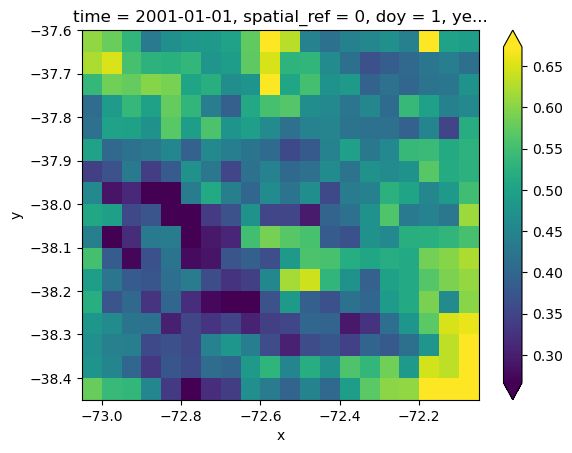

In [5]:
img.isel(time=0).plot(robust=True)

Text(0, 0.5, 'SIF [$Wm^{-2}nm^{-1}sr^{-1}$]')

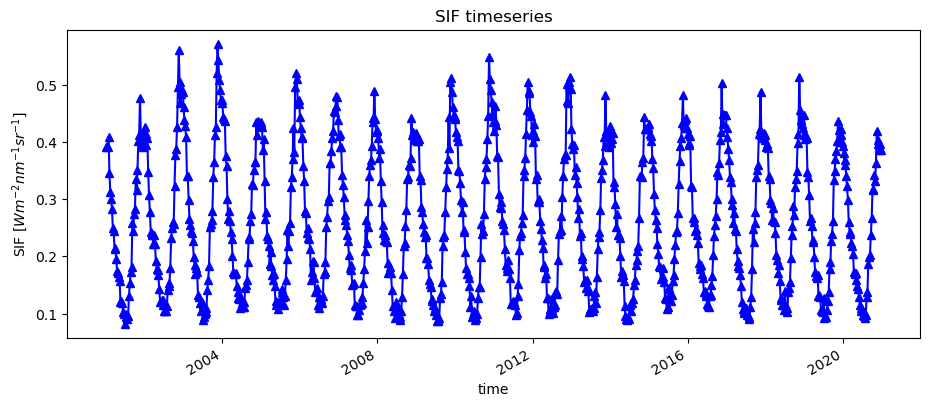

In [6]:
img.isel(x=5, y=5).plot.line('b-^', figsize=(11,4))
plt.title('SIF timeseries')
plt.ylabel('SIF ['r'$Wm^{-2}nm^{-1}sr^{-1}$]')

Text(0, 0.5, 'SIF [$Wm^{-2}nm^{-1}sr^{-1}$]')

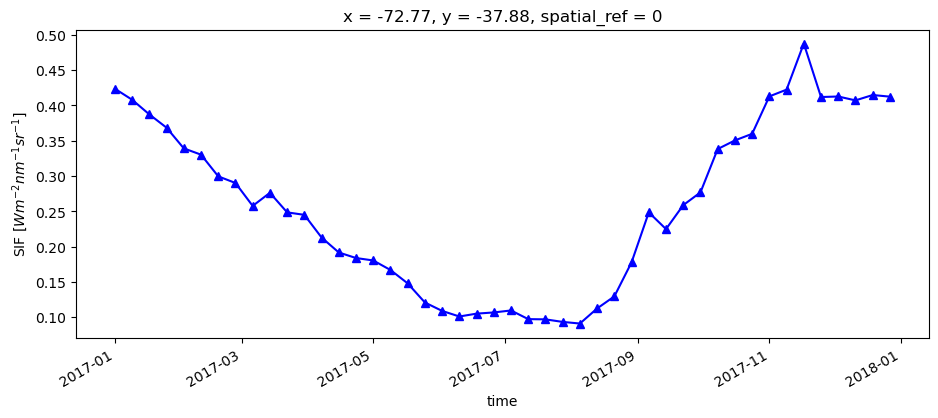

In [7]:
# plot one year time series
img.where(img.year == 2017, drop=True).isel(x=5, y=5).plot.line('b-^', figsize=(11,4))
plt.ylabel('SIF ['r'$Wm^{-2}nm^{-1}sr^{-1}$]')


Text(0, 0.5, 'SIF [$Wm^{-2}nm^{-1}sr^{-1}$]')

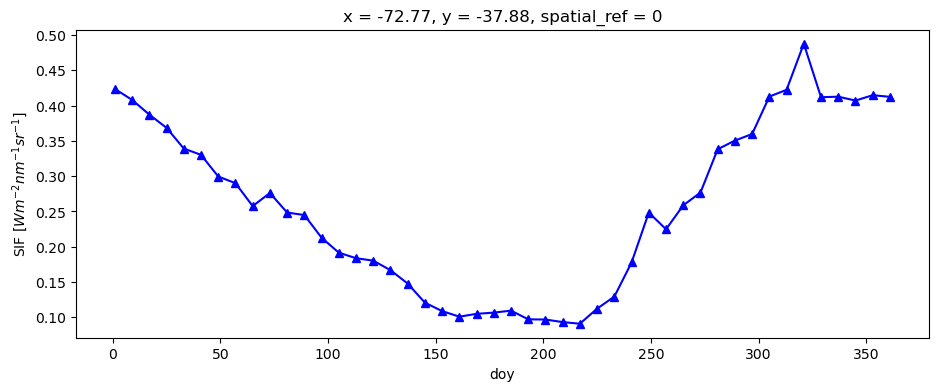

In [8]:
# plot one year time series by doy
img.where(img.year == 2017, drop=True).isel(x=5, y=5).plot.line('b-^', x='doy', figsize=(11,4))
plt.ylabel('SIF ['r'$Wm^{-2}nm^{-1}sr^{-1}$]')


As you can see, if you take only yearly data you may end up with many gaps in the data. So, if you are interested in stable land surface phenology (LSP) metrics, you may want to mix several years together to fill the gaps with other years information:

<AxesSubplot: xlabel='Day of the year', ylabel='NDVI'>

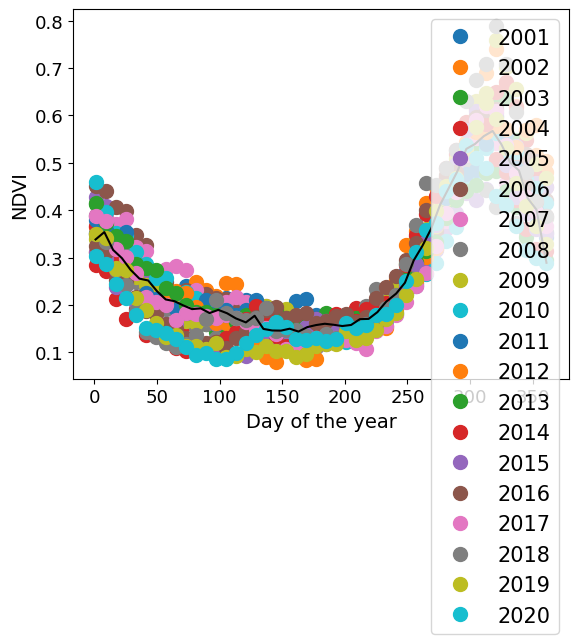

In [9]:
# Use the PhenoPlot function with an example X, Y coordinates to play with interpolation parameters.

X = np.median(img.x.values)
Y = np.median(img.y.values)

PhenoPlot(img, X, Y, interpolType='linear', rollWindow=5, plotType=1)

As we are in the souther hemosphere in this case, the typical order of DOY does not give us the necesary phenological shape for rstimating Land Surface Phenology (LSP) metrics.

Hence, we can create pseudo-DOYs for fitting the necesary data and then correct for the real DOY values when plotting.

In [10]:
### Change the DOY order for southern hemisphere

from utils import reorder_southern_hemisphere

reordered_doy, south_img = reorder_southern_hemisphere(img)
south_img

<xarray.DataArray (time: 920, y: 17, x: 20)>
[312800 values with dtype=float32]
Coordinates:
  * time         (time) datetime64[ns] 2001-07-04 2002-07-04 ... 2020-06-25
  * x            (x) float64 -73.02 -72.97 -72.92 ... -72.17 -72.12 -72.07
  * y            (y) float64 -37.63 -37.68 -37.73 ... -38.33 -38.38 -38.43
    spatial_ref  int64 0
    doy          (time) float64 1.0 1.396 1.792 2.188 ... 364.2 364.6 365.0
    year         (time) int32 2001 2002 2003 2004 2005 ... 2017 2018 2019 2020
Attributes:
    _FillValue:    -3.3999999521443642e+38
    scale_factor:  1.0
    add_offset:    0.0

Text(0.5, 1.0, 'SIF timeseries in the southern hemisphere with pseudo-doy')

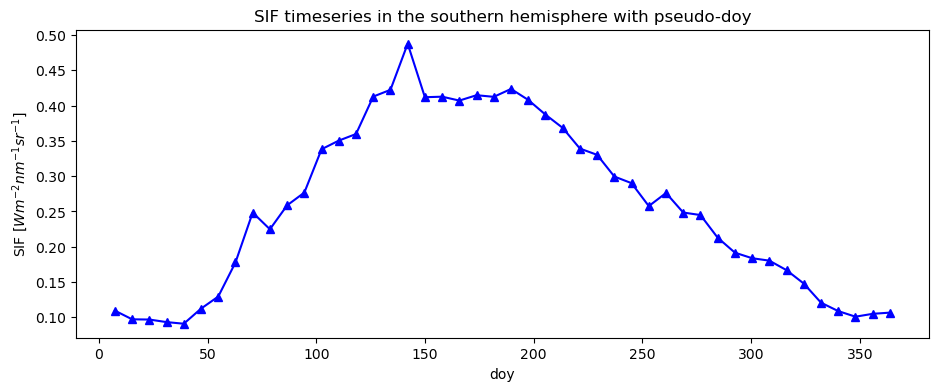

In [11]:
# plot one year time series by doy in the reordered dataset for southern hemisphere
south_img.where(south_img.year == 2017, drop=True).isel(x=5, y=5).plot.line('b-^', x='doy', figsize=(11,4))
plt.ylabel('SIF ['r'$Wm^{-2}nm^{-1}sr^{-1}$]')
plt.title('SIF timeseries in the southern hemisphere with pseudo-doy')

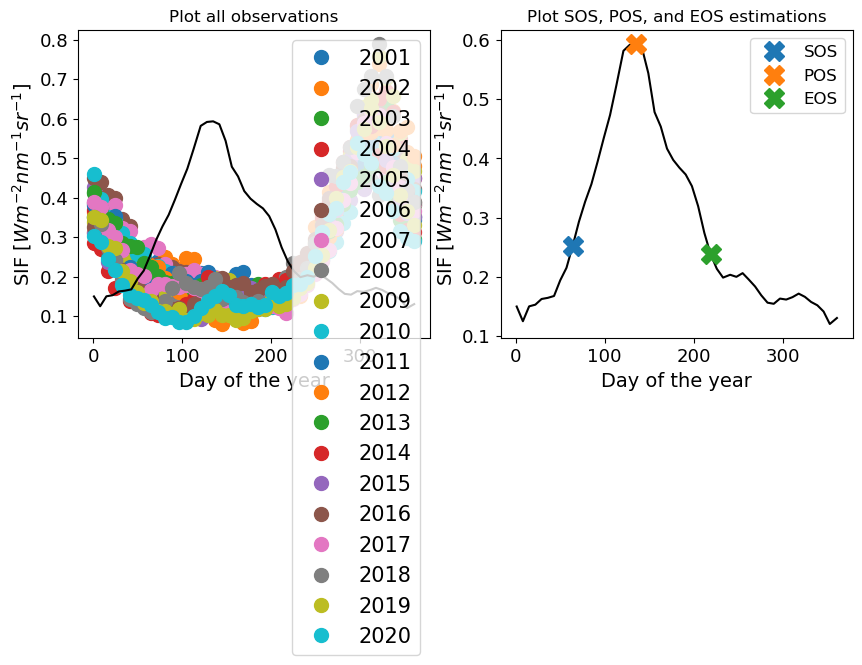

In [12]:
### TODO: FIX PLOTTING OF DOTS (YEARS) AND INTERPOLATION

# test model parameter using a 2D plot

# example coordinates for testing
X = np.median(img.x.values)
Y = np.median(img.y.values)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the DataArrays side by side
PhenoPlot(south_img, X, Y, 'linear', rollWindow=5,
          plotType=1, ax=axes[0], ylab='SIF ['r'$Wm^{-2}nm^{-1}sr^{-1}$]')

PhenoPlot(south_img, X, Y, 'linear', rollWindow=5,
          plotType=2, ax=axes[1], ylab='SIF ['r'$Wm^{-2}nm^{-1}sr^{-1}$]')

axes[0].set_title("Plot all observations")
axes[1].set_title("Plot SOS, POS, and EOS estimations")

# Display the plots
plt.show()


Now we can estimate an interannual phenological shape using all year and heve summer time in the middle of the season.

Using multi-year data, PhenoPy is able to fill the gaps and fit a single phenological shape from which estimate phenological parameters, such as the start of the season (SOS), the peak of season (POS), and the end of season (EOS). You can check if these values are correctly assessed by using type=2 in PhenoPlot:

Estimate Phenological shape to the raster using the same parameters. Here we are using weekly interpolations (nGS=52), linear interpolation and a rollWindow of 5 for smoothing.

In [13]:
# PhenoShape
shape = img.pheno.PhenoShape(rollWindow=5)
shape_south = south_img.pheno.PhenoShape(rollWindow=5)

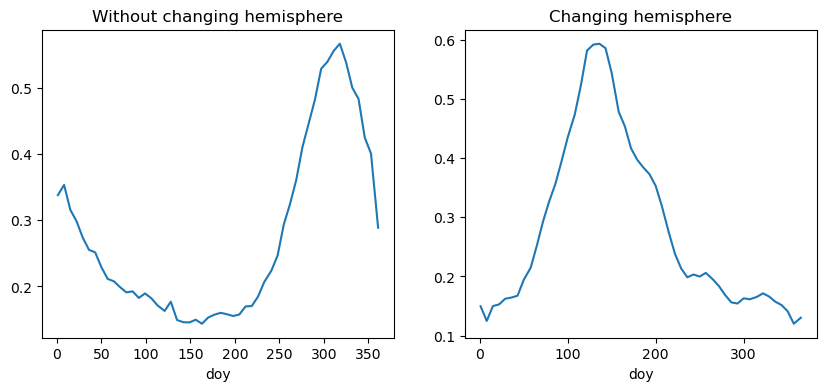

In [14]:
# plot with selected xy coordinates and use the closest real values if the selected xy is not in the original data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the DataArrays side by side
shape.sel(x=X, y=Y, method="nearest").plot(ax=axes[0])
shape_south.sel(x=X, y=Y, method="nearest").plot(ax=axes[1])

axes[0].set_title("Without changing hemisphere")
axes[1].set_title("Changing hemisphere")

# Display the plots
plt.show()

<AxesSubplot: title={'center': 'y = -38.03, x = -72.52'}, xlabel='doy', ylabel='SIF [$Wm^{-2}nm^{-1}sr^{-1}$]'>

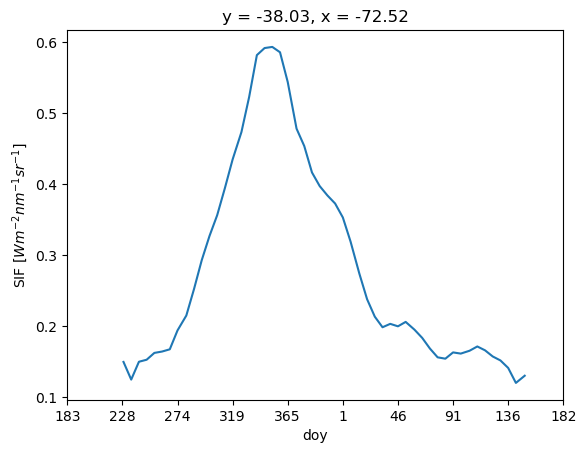

In [15]:
# reorder xlabels for southern hemisphere
plot_with_southern_doy(shape_south, coordinates=[X,Y], ylabel='SIF ['r'$Wm^{-2}nm^{-1}sr^{-1}$]')

### Test if all pixels are convex, i.e. with productivity peaks in "summer" of in the middle of the year. 

Here, we used the sum of the second derivative of a vector. Positive values are concave (valleys), negative convex (peaks), and close to zero are flat shapes


In [16]:
curvature = get_curvature(shape_south)
#curvature2 = get_curvature(img)

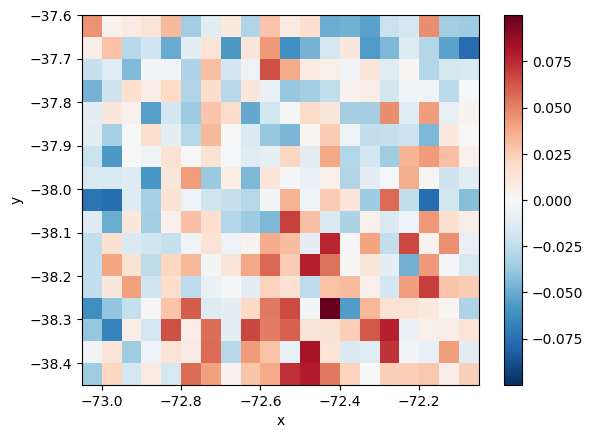

In [17]:
curvature.plot()

We can estimate the LSP metrics for the raster. Until now, the metrics included are:

SOS - DOY of Start of season \
POS - DOY of Peak of season \
EOS - DOY of End of season \
vSOS - Vaues at start os season \
vPOS - Values at peak of season \
vEOS - Values at end of season \
LOS - Length of season \
MSP - Mid spring (DOY) \
MAU - Mid autum (DOY) \
vMSP - Value at mean spring \
vMAU - Value at mean autum \
AOS - Amplitude of season \
IOS - Integral of season [SOS-EOS] \
ROG - Rate of greening [slope SOS-POS] \
ROS - Rate of senescence [slope POS-EOS] \
SW - Skewness of growing season [SOS-EOS]

In [18]:
# Land surface phenology metrics (LSP)
lsp = shape_south.pheno.PhenoLSP()
lsp

<xarray.Dataset>
Dimensions:  (y: 17, x: 20)
Coordinates:
  * y        (y) float64 -37.63 -37.68 -37.73 -37.78 ... -38.33 -38.38 -38.43
  * x        (x) float64 -73.02 -72.97 -72.92 -72.87 ... -72.17 -72.12 -72.07
Data variables: (12/16)
    sos      (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    pos      (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    eos      (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    vsos     (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    vpos     (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    veos     (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    ...       ...
    vmau     (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    ampl     (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    ios      (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    rog      (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    ros      (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    sw       (y, x) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>

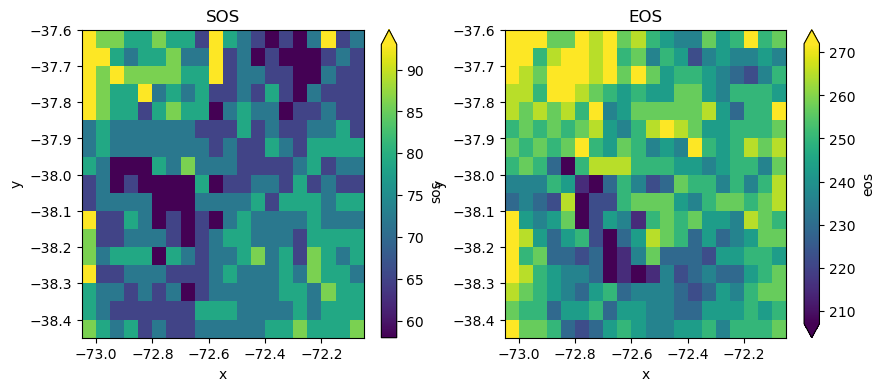

In [19]:
# plot lsp.sos.plot(robust=True) and lsp.eos.plot(robust=True) in the same figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the DataArrays side by side
lsp.sos.plot(ax=axes[0], robust=True)
lsp.eos.plot(ax=axes[1], robust=True)

axes[0].set_title("SOS")
axes[1].set_title("EOS")

# Display the plots
plt.show()    


We can also estimate the interannual variability of the phenological metrics by calculating the root mean square error of the sognal.

See Lopatin (2023; https://ieeexplore.ieee.org/document/10128132).

E.g., 

<img src="data/Fig_Segmented_nRMSE.jpg" alt="" width="700"/>

In [22]:
rmse = shape_south.pheno.RMSE(img, LSP_stack=lsp, normalized=False)
rmse2 = shape_south.pheno.RMSE(img, LSP_stack=lsp, normalized=True)

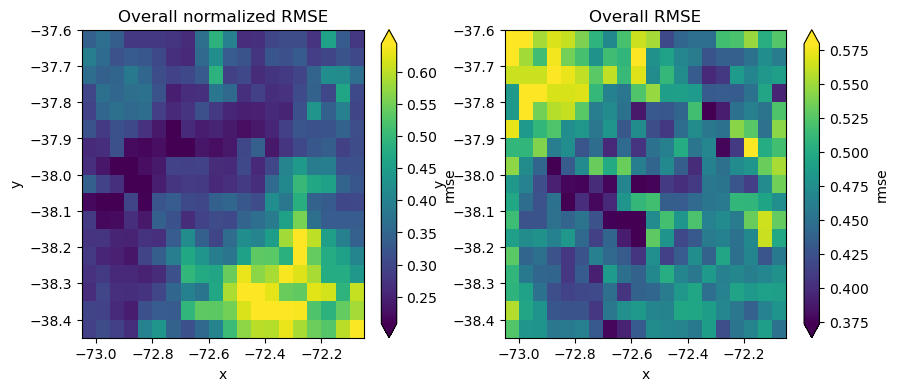

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the DataArrays side by side
rmse.rmse.plot(ax=axes[0], robust=True)
rmse2.rmse.plot(ax=axes[1], robust=True)

axes[0].set_title("Overall normalized RMSE")
axes[1].set_title("Overall RMSE")

# Display the plots
plt.show()

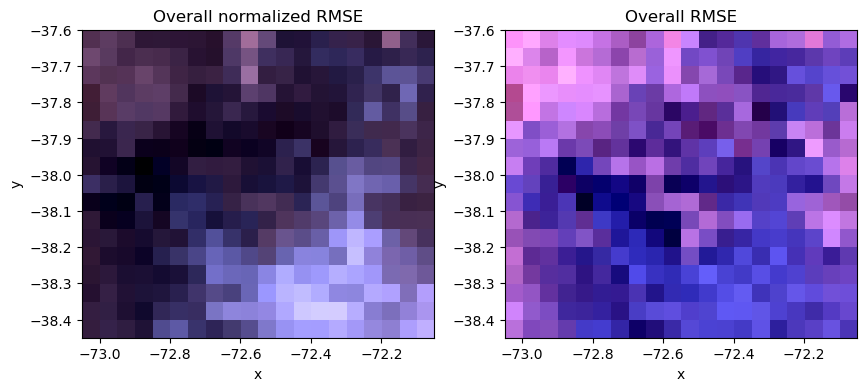

In [26]:
# plot RMSE RGB-based figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the DataArrays side by side
rmse.to_array()[[3, 2, 1], :, :].plot.imshow(ax=axes[0], robust=True)
rmse2.to_array()[[3, 2, 1], :, :].plot.imshow(ax=axes[1], robust=True)

axes[0].set_title("Overall normalized RMSE")
axes[1].set_title("Overall RMSE")

# Display the plots
plt.show()